In [1]:
%reload_ext autoreload
%autoreload 2

In [69]:
model_name = 'microresnet#4-gate=3x3-n=1-se=True'
model_dir = '/home/francesco/Desktop/carino/vaevictis/data/microresnet#4-gate=3x3-n=1-se=True--0.001-0.66-1556891328.1860957'

In [ ]:
%matplotlib notebook

In [14]:
import rospy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib

from utilities.patches import *
from utilities.postprocessing.utils import KrockPatchExtractStrategy

from estimators.data.TraversabilityDataset import PatchesDataset
from estimators.data.transformations import get_transform
from estimators.utils import get_learner, get_probs_and_labels_from_preds
from estimators.callbacks import ROC_AUC
from utilities.pipeline import *


from jupyterthemes import jtplot
jtplot.reset()

plt.style.use(['science'])
matplotlib.rcParams['figure.figsize'] = (5,4)
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""


/home/francesco/.local/lib/python3.6/site-packages/skimage/novice/__init__.py:103: UserWarning: The `skimage.novice` module was deprecated in version 0.14. It will be removed in 0.16.
  warnings.warn("The `skimage.novice` module was deprecated in version 0.14. "


In [5]:
TR = 0.2

### Test the model on custom patches
We can start by testing the model on synthetic patches using the `Patches` library. We fist must select and advancement in a time window. We are going to use a maximum adnvamcent of `66cm` that corespond to a time window of `2` seconds. In this case, the pach size is.

In [6]:
MAX_ADVANCEMENT = 0.66
patch_shape = KrockPatchExtractStrategy.patch_shape(MAX_ADVANCEMENT)
patch_shape

(76, 76)

#### Wall forward
One of the more straightforward and easier test we can try is to place a wall in front of the robot. Rember, the krock center is at 71cm from the left, but we have to place the wall in front of his head, so around 85cm. To make sure the wall is not under krock, we will spawn the wall at 90cm. We will use a resolution of 0.02 cm per pixel.

<IPython.core.display.Javascript object>


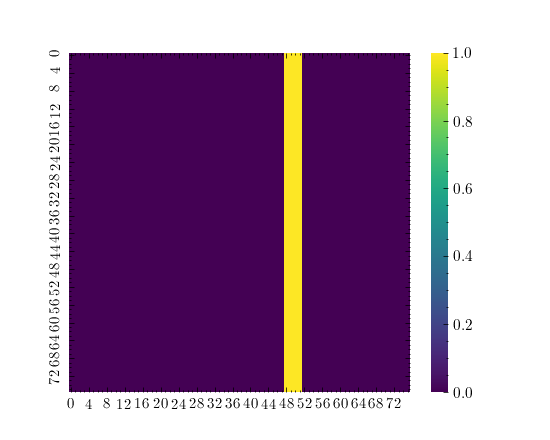

<IPython.core.display.Javascript object>


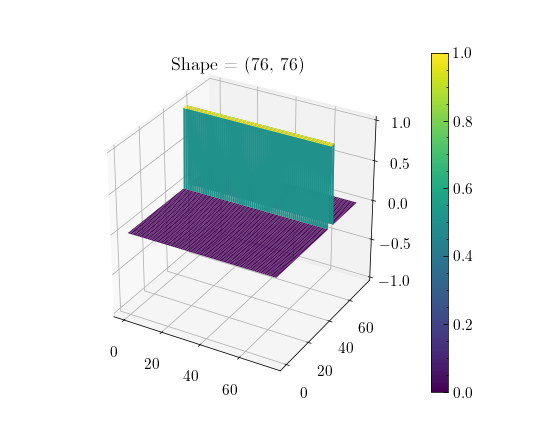

(<Figure size 500x400 with 2 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fca527d3668>)

In [42]:
res = 0.02
krock_body = 0.85 // res
surely_in_front_of_krock = int(krock_body + 10)
offset = patch_shape[1] - surely_in_front_of_krock
p = WallPatch(shape=patch_shape, strength=1, offset=offset, back=False)
p()
p.plot2d()
p.plot3d()

Let's define our pipeline to get an answer

In [70]:
from functools import partial

get_answer_from_model = Compose([get_learner, 
         lambda x: x[0].get_preds(), 
         get_probs_and_labels_from_preds])

get_answer = partial(get_answer_from_model,model_name,
                      model_dir, 
                      [])
answer = get_answer(dataset=PatchesDataset([p], get_transform(debug=True)))

In [65]:
answer

(tensor([[1., 0.]]), tensor([0]))

In [45]:
tensor2class = lambda x : {0: 'non traversable', 1 : 'traversable'}[x]

def answer2human(answer):
    probs = answer
    label = int(torch.argmax(probs).item())
    print('Model thinks it is "{}" with prob = {:.2f}%'.format(tensor2class(label), 
                                                                   probs[label] * 100))

In [46]:
def plot_probs(probs):
    fig = plt.figure()
    plt.title('Traversability probability over patches')
    plt.plot(probs[:,0], label='not traversable')
    plt.plot(probs[:,1], label='traversable')
    plt.legend()
    return fig

In [47]:
answer2human(answer[0][0])

Model thinks it is "non traversable" with prob = 100.00%


This makes sense, Krock cannot traverse a one meter tall wall in front of him. We can test the robustnees of our model by keeping the same height but changing the wall width. The results should always be the same

<IPython.core.display.Javascript object>


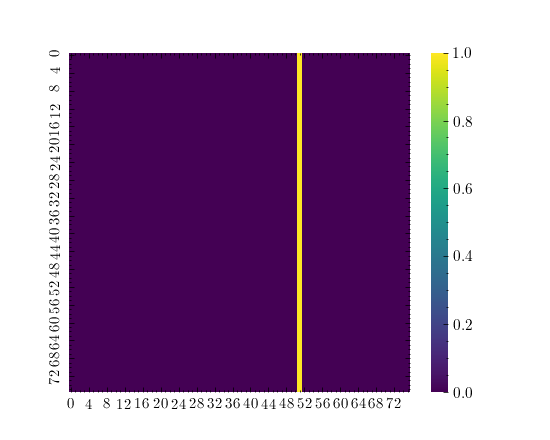

<IPython.core.display.Javascript object>


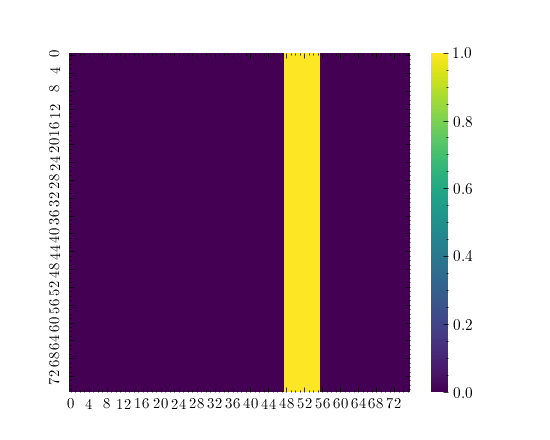

In [48]:
patches = [WallPatch(KrockPatchExtractStrategy.patch_shape(0.66), 
                     strength=1, 
                     back=False, 
                     offset=offset - int(s//2),
                     size=int(s))() for s in np.linspace(1, 8, 8)]
patches[0].plot2d()
patches[-1].plot2d()

In [49]:
get_answer(dataset=PatchesDataset(patches, get_transform()))[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0])

Perfect all patches are non traversable

### Which wall can Krock  traverse?
What if we want to find out the maximum wall height krock can traverse. Let's create 100 walls where we increase the wall size by one cm at the time.

<IPython.core.display.Javascript object>


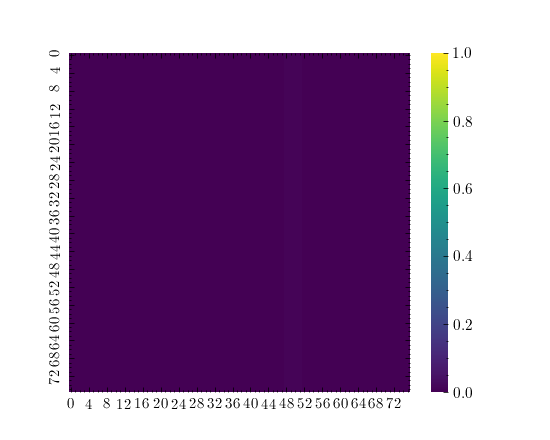

<IPython.core.display.Javascript object>


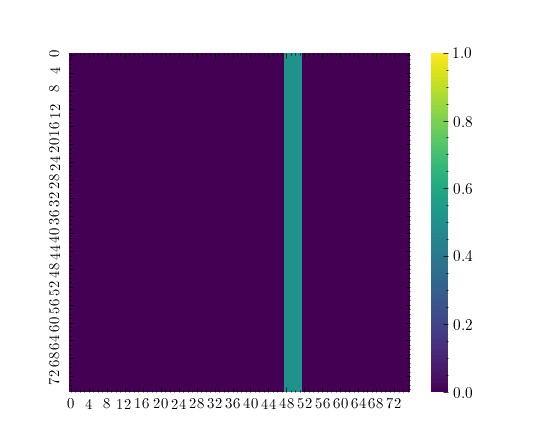

<IPython.core.display.Javascript object>


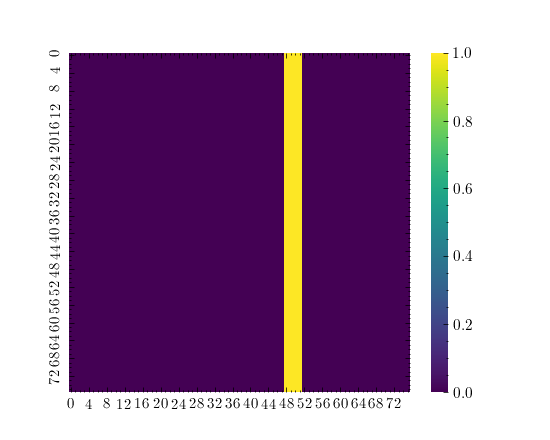

In [73]:

patches = [WallPatch(KrockPatchExtractStrategy.patch_shape(0.66), strength=s, back=False, offset=offset)() for s in np.linspace(0.01, 1, 100)]

patches[0].plot2d()
patches[50].plot2d()
patches[-1].plot2d()

Let's get out answers.

In [135]:
ds = PatchesDataset(patches, get_transform())
probs, labels = get_answer(dataset=ds)
labels

tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

So more than 7cm won't make krock able to traverse a patch. We remember to the reader that krock is 13cm height in the gait configuration we used. Let's see how its prediction evolve with the increasing of the walls

<IPython.core.display.Javascript object>


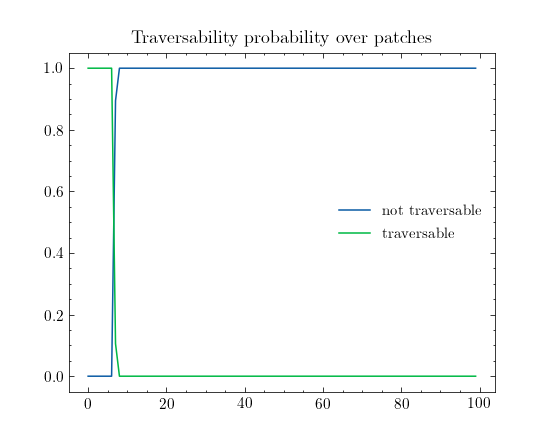

In [75]:
_ = plot_probs(probs)

In [88]:
answer2human(probs[7])

Model thinks it is "non traversable" with prob = 89.44%


We can load the patch into Webots, and see what would be the real advancement from the simulation

In [85]:
from simulation.env.webots.krock import KrockWebotsEnv
from simulation.env.spawn import spawn_points2webots_pose
from simulation.agent.callbacks import RosBagSaver


class KrockWebotsPatches(KrockWebotsEnv):
    world_path = '/home/francesco/Documents/Master-Thesis/core/simulation/env/webots/krock/krock_no_tail_patches.wbt'
    output_dir = '/home/francesco/Documents/Master-Thesis/core/simulation/env/webots/krock/krock2_ros/worlds'
    bags_out_dir = '/tmp/'
    bag_name = 'patches_bag'
    
    def reset(self):
        y = self.y_dim// 2
        x = 36
        print(x, y)
        pose = spawn_points2webots_pose([x,y], self, orientation=[0,0,0,0])
        super().reset(pose=pose)
        
    def run(self, for_seconds):
        self.reset()
        elapsed = 0
        start = time.time()
        while elapsed <= for_seconds:
            elapsed = time.time() - start
            obs, r, done, _ = self.step(self.GO_FORWARD)
        self.agent.die(self,  self.bag_name)
        obs, r, done, _ = self.step(self.STOP)
        
        return self.bag_name
        
    @classmethod
    def from_patch(cls, patch, *args, **kwargs):
        rospy.init_node("patches_simulation")
        return cls.from_numpy(patch.hm * 255,
                              cls.world_path,
                              {'height': 1,
                               'resolution': 0.02 },
                              agent_callbacks=[RosBagSaver(cls.bags_out_dir, topics=['pose'])],
                              output_path=cls.output_dir + '/tmp.wbt')

def run_patch_on_simulator(p, for_seconds):
    env = KrockWebotsPatches.from_patch(p)
    return env.run(for_seconds)


The code to read the bag file on the fly and get the advancement

In [159]:
from utilities.postprocessing.postprocessing import Bags2Dataframe, ParseDataframe, AddAdvancement
import pandas as pd

TIME_WINDOW = 50 * 2

get_advancement = Compose([
    Bags2Dataframe(KrockWebotsPatches.bags_out_dir + '/'),
    ParseDataframe(),
    AddAdvancement(TIME_WINDOW),
    lambda x: x[0],
    lambda df: df.reset_index(drop=True),
    lambda df:  (df['advancement'][0], df)
])


run_patches_on_simulator_and_get_advancement = Compose([
    run_patch_on_simulator,
    get_advancement
])

def average_run_patches_on_simulator_and_get_advancement(n, *args, **kwargs):
    dfs = [run_patches_on_simulator_and_get_advancement(*args, **kwargs)[1] for _ in range(n)]
    mean_adv = np.array(list(map(lambda x : x['advancement'][0], dfs))).mean()
    
    return mean_adv, dfs

Let's see wha the real Krock would have done 

In [161]:
adv, _ = run_patches_on_simulator_and_get_advancement(patches[6], 5)
adv

36 38
success: 1


0.2800304327823883

Krock was able to traversa that patch

### Moving the wall to the right
Since we select a treshold smaller than the maximum advancement on the flat ground, moving the a wall that is not traversable in front of the robot to the edge should make a patch traversable since on the flat ground the robot is actually able to go faster. While moving the same wall in front of the robot must yield zero advancament

Since our threshold is

In [176]:
print(TR)

0.2


We should espect the patch to become not traversable when the wall is at 20cm from the krock tail. So, we should place the wall extractly at 85cm + 20cm on the patch

<IPython.core.display.Javascript object>


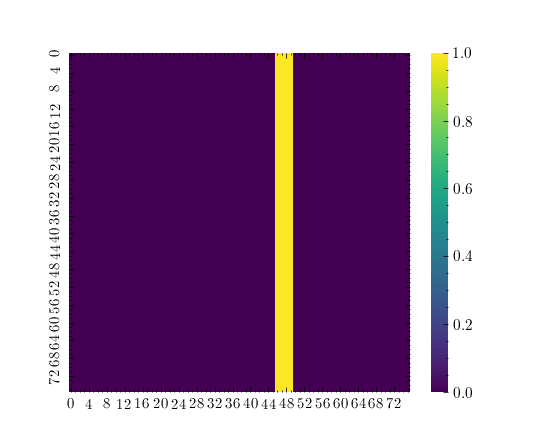

In [177]:
offset_in_tr = int( patch_shape[1] - (krock_body + (TR // res)))
wall_size = 4
p_not_trav = WallPatch(patch_shape, offset=offset_in_tr + wall_size//2, back=False, size=wall_size)()
p_not_trav.plot2d()

In [178]:
ds = PatchesDataset([p_not_trav], get_transform())
answer2human(get_answer(dataset=ds)[0][0])

Model thinks it is "non traversable" with prob = 100.00%


Correctly the model says that it is not traversable since the obstacle is included in our treshold. Let's try with the simulator

In [179]:
adv, _ = run_patches_on_simulator_and_get_advancement(p_not_trav, 5)
adv

36 38
success: 1


0.02238049175108624

The robot is stuck.

Let's try to make a huge wall, 10 meters tall, on the right edge. The height should not influence the prediction

Model thinks it is "traversable" with prob = 100.00%


<IPython.core.display.Javascript object>


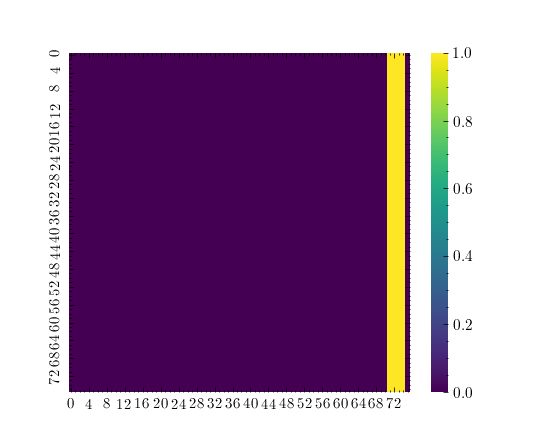

In [180]:
p_trav = WallPatch(patch_shape, strength=1, offset=1, back=False)()
answer2human(get_answer(dataset=PatchesDataset([p_trav], get_transform(scale=10)))[0][0])
p_trav.plot2d()

In [181]:
adv, _ = run_patches_on_simulator_and_get_advancement(p_trav, 5)
adv

36 38
success: 1


0.34674425637524064

Correctly, the model do not necessary correlate height and traversability.

### Grad Cam

- [ ] Explain what Grad Cam is

In [169]:
from mirror.visualisations.core.GradCam import GradCam
from estimators.utils import load_model_from_name

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = load_model_from_name(model_dir + '/roc_auc.pth', model_name )

def tensor2numpyim(tensor):
    print(tensor)
    return tensor.permute(1,2,0).cpu().numpy()

grad_cam = Compose([
    lambda batch: batch[0],
    lambda x: x.unsqueeze(0).to(device),
    GradCam(model, device),
    lambda x: x[1]['cam'],
    lambda x: Patch.from_hm(x / 255),
])

def answer_with_grad_cam(data):
    batch, probs, label, cam = data 
    x = Patch.from_tensor(batch[0])
    answer2human(probs)
    x.plot2d(title='Input')
    cam.plot2d(title='Grad cam')
    
    return x, probs, label, cam

def get_answer_with_grad_cam(ds):
    comb = Combine()(ds,  *get_answer(dataset=ds), ForEachApply(grad_cam)(ds))  
    return ForEachApply(answer_with_grad_cam)(comb)

Model thinks it is "non traversable" with prob = 100.00%


<IPython.core.display.Javascript object>


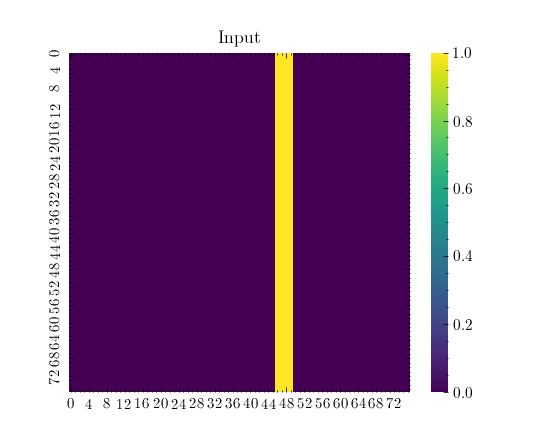

<IPython.core.display.Javascript object>


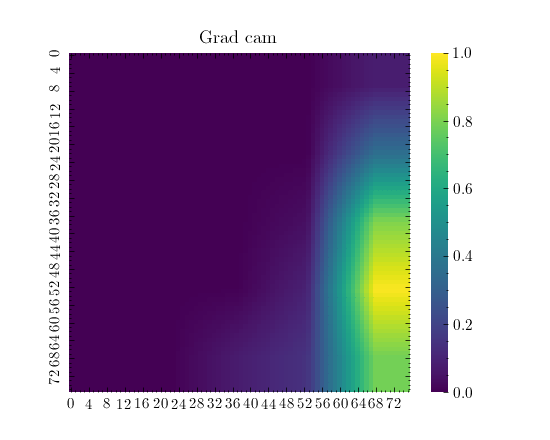

Model thinks it is "traversable" with prob = 100.00%


<IPython.core.display.Javascript object>


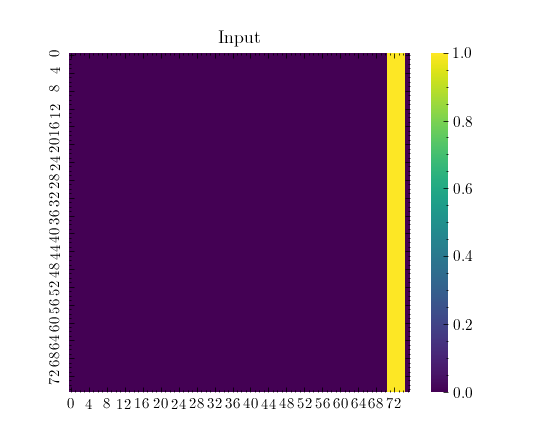

<IPython.core.display.Javascript object>


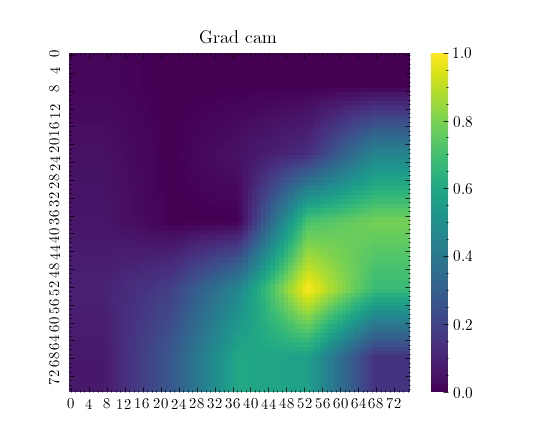

[(Shape = (76, 76), tensor([1., 0.]), tensor(0), Shape = (76, 76)),
 (Shape = (76, 76), tensor([0., 1.]), tensor(1), Shape = (76, 76))]

In [184]:
list(get_answer_with_grad_cam(PatchesDataset([p_not_trav, p_trav], get_transform())))

In [ ]:
import gc
gc.collect()

In [18]:
from opensimplex import OpenSimplex
simplex = OpenSimplex()
import numpy as np
from tqdm import tqdm_notebook as tqdm

def im2simplex(im, feature_size=24, scale=10):
    h, w = im.shape[0], im.shape[1]
    for y in range(0, h):
        for x in range(0, w):
            value = simplex.noise2d(x / feature_size, y / feature_size)
            im[x,y] += value / scale
    return im

In [32]:
r = RandomSimplexNoise()
images = []
img = np.zeros((76,76))
for _ in tqdm(range(10)):
    images.append(r(img.copy()))

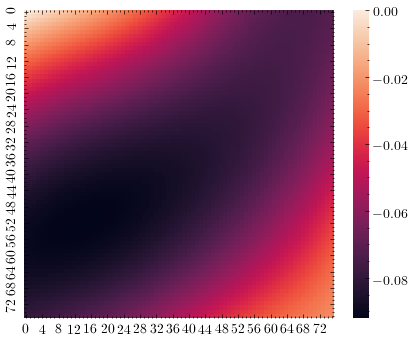

(76, 76)

In [33]:
plt.figure()
sns.heatmap(images[2])
plt.show()
images[2].shape

In [20]:
class RandomSimplexNoise():
    def __call__(self, img):
        features_size = np.random.randint(1, 100)
        scale = np.random.randint(7, 10)
        return im2simplex(img, features_size, scale)

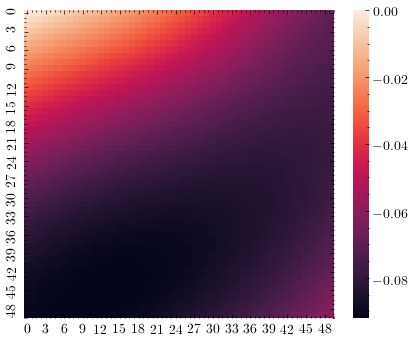

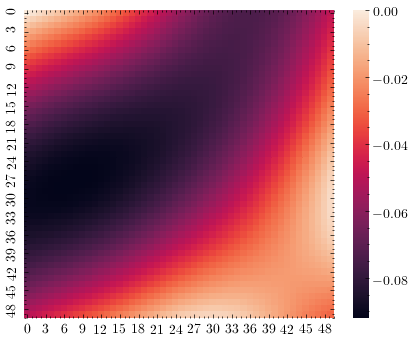

In [21]:
im = im2simplex(np.zeros((76,76)), 50, scale=3)

r = RandomSimplexNoise()
for _ in range(2):
    plt.figure()
    im = r(np.zeros((50,50)))
    sns.heatmap(im)
    plt.show()


<IPython.core.display.Javascript object>


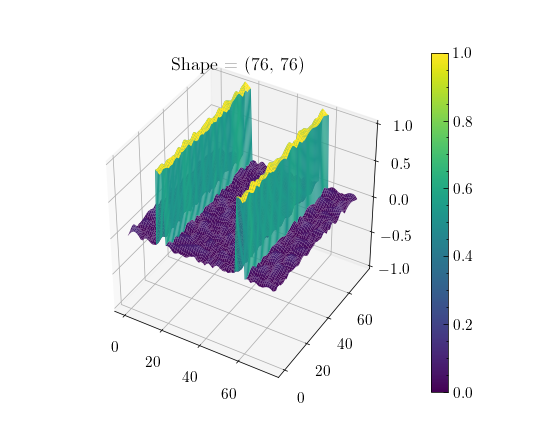

(<Figure size 500x400 with 2 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f7e4cb39be0>)

In [261]:
p = BarPatch(patch_shape)()
im = RandomSimplexNoise()(p.hm)
Patch.from_hm(im).plot3d()